# Variant Calling
For targeted gene panels, the recommended best practices workflow (by Broad Institute) relies on hard variant filtering. Given the limited size of such data sets Variant Quality Score Recalibration (VQSR) workflow that leverages ML algorithms cannot be applied. For hard variant filtering workflow, Broad Institute recommends a set of filters and respective cutoffs that mimic VQSR results. These are to be further fine-tuned for a specific sample and project needs. Targeted sequencing-based gene panels, in general require more stringent cutoffs, to guarantee an optimal performance in clinical settings.

* In this notebook, we visualise customise cutoffs for hard variant filtering (SNPs only)
* Validate SNP calls done via GATK4 best practices workflow against Golder Reference
* Compare the results of GATK4 calls with the initial SG001_1 results

**Implemented GATK4 pipeline**
1. Pre-processing of bam file (1.6% of duplicate reads removed)
2. Base quality score recalibration using high-confidence variant calls from NIST (Genome in a Bottle) https://www.nist.gov/programs-projects/genome-bottle
3. Variant calling
4. Hard filtering of variants

**Only SG001_1 sequencing library is used for variant calling**

## Main Insights
* More stringent than recommened filtering of MappingQualityRankSumTest and FisherStrand filters allows achieveing optimal variant calls
* GATK4 method outperforms baseline method by achieving 100% precision in exteded benchmark areas (more variants without false positives)

In [1]:
import vcf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys

In [2]:
# setup paths 
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

from src.utils.vcf import read_vcf_data, read_vcf_meta, extract_attr, accuracy_metrics
from src.utils.plot import truncate_colormap, make_boxplot, plot_var_venn
from src.utils.plot import plot_nice_barplot, show_samplots_image
from src.utils.msg import print_samstats_message, get_sam_stat, print_samstats_mismatch, print_sams_pairstats
from src import config

In [3]:
filename = "gatk/SG001_1_gatk_snp.vcf"
vcf_dict, samples = read_vcf_data(os.path.join(config.DATA_INTERIM_PATH, filename))
vcf_info, vcf_filters = read_vcf_meta(os.path.join(config.DATA_INTERIM_PATH, filename))
print(f"Total raw SNPs in file: {len(vcf_dict)}")

Total raw SNPs in file: 68


## Customisation of Hard Filtering Thresholds
The goal is to find sufficiently stringent cutoffs that recover all SNPs in target regions.

**Analytical Flow**
1. Visualize the distribution of the underlying annotations for each filter for raw variant calls.
2. Based on the distribution identify cases to apply more stringent cutoff than recommended by Broad institute. 
3. Visually inspect variants filtered out by more stringent cutoffs in IGV html one pager:
   
    * [IGV viewer](/files/data/processed/igv_viewer_gatk.html) - **CLICK inside the container** to visualise the alignments in new tab

In [4]:
attrs = {"QD": "QualByDepth",
         "MQ":"RMSMappingQuality",
         "SOR":"StrandOddsRatio",
         "FS":"FisherStrand",
         "MQRankSum":"MappingQualityRankSumTest",
         "ReadPosRankSum":"ReadPosRankSumTest"
          }

cutoffs = {"QD": 2,
           "MQ":40,
           "SOR":3,
           "FS":60,
           "MQRankSum":-12.5,
           "ReadPosRankSum":-8
           }

new_cutoffs = {"FS":8,
               "MQRankSum":-1
               }

#### Use more stingent cutoff for FisherStrand (FS) filter
This is the Phred-scaled probability that there is strand bias at the site. Strand Bias tells us whether the alternate allele was seen more or less often on the forward or reverse strand than the reference allele. When there is little or no strand bias at the site, the FS value will be close to 0.
  
The generic filtering recommendation for FS is to filter out variants with FS above 60. However none of the raw variants in the current data set reaches 60. The distribution below shows that most raw variants cluster around 0 suggesting no strand bias. To the right of the distribution there is a "shoulder" of outlier variants with a higher FS from 8 to 10, clearly visible in the boxplot below.

* **New cutoff: filter out variants with FS > 8.0**

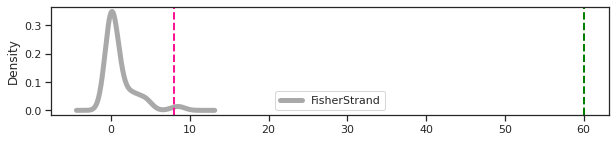

In [5]:
attr = 'FS'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=new_cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.axvline(x=cutoffs[attr], linewidth=2, color='Green', ls='--')
plt.show()

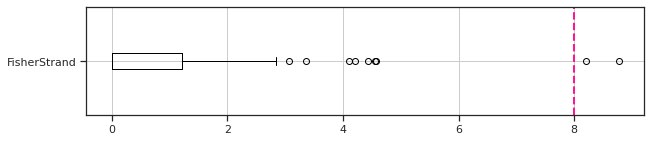

In [6]:
df.boxplot(color='black', figsize=(10,2), vert=False)
plt.axvline(x=new_cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

#### Use more stingent cutoff for MappingQualityRankSumTest (MQRankSum) filter
This is the u-based z-approximation from the Rank Sum Test for mapping qualities. It compares the mapping qualities of the reads supporting the reference allele and the alternate allele. A positive value means the mapping qualities of the reads supporting the alternate allele are higher than those supporting the reference allele; a negative value indicates the mapping qualities of the reference allele are higher than those supporting the alternate allele. A value close to zero is best and indicates little difference between the mapping qualities.
  
The generic filtering recommendation for MQRankSum is to filter out variants with MQRankSum below -12.5. In the current data set there are no variants close to this value. The distribution below shows that most raw variants cluster around 0 suggesting little difference between mapping qualities for reference and alternative alleles. To the left of the distribution there are several outlier variants with a MQRankSum lower than -0.5, shown on the boxplot below.

* **New cutoff: filter out variants with MQRankSum < -1**

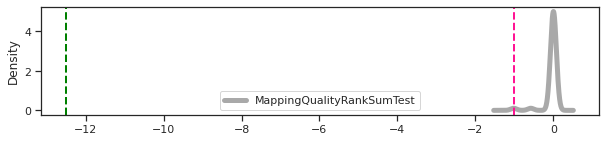

In [7]:
attr = 'MQRankSum'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=new_cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.axvline(x=cutoffs[attr], linewidth=2, color='Green', ls='--')
plt.show()

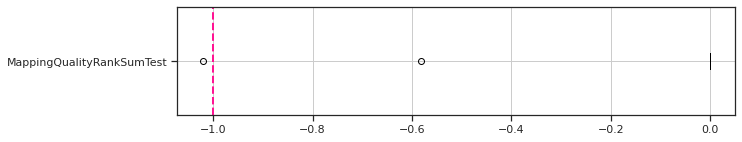

In [8]:
df.boxplot(color='black', figsize=(10,2), vert=False)
plt.axvline(x=new_cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

#### Use recommended QualByDepth (QD) filter
This is the variant confidence (from the QUAL field) divided by the unfiltered depth of non-hom-ref samples. This annotation is intended to normalize the variant quality in order to avoid inflation caused when there is deep coverage. For filtering purposes it is better to use QD than either QUAL or DP directly.

The generic filtering recommendation for QD is to filter out variants with QD below 2. The distribution below with two major peaks around 12 and 30 supports the recommended cutoff.

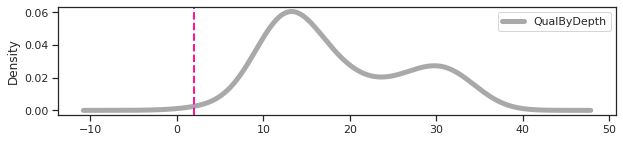

In [9]:
attr = 'QD'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

#### Use recommended RMSMappingQuality (MQ) filter
This is the root mean square mapping quality over all the reads at the site. Instead of the average mapping quality of the site, this annotation gives the square root of the average of the squares of the mapping qualities at the site. It is meant to include the standard deviation of the mapping qualities. Including the standard deviation allows us to include the variation in the dataset. A low standard deviation means the values are all close to the mean, whereas a high standard deviation means the values are all far from the mean.When the mapping qualities are good at a site, the MQ will be around 60.  
  
The generic filtering recommendation for MQ is to filter out variants with MQ below 40. The distribution below supports the recommended cutoff, as exppected MQ for all raw variants is around 60.

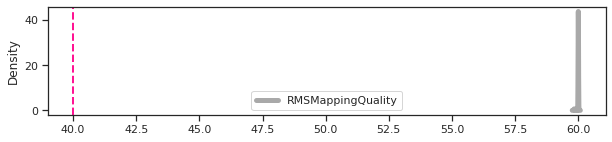

In [10]:
attr = 'MQ'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

#### Use recommended StrandOddsRatio (SOR) filter
This is another way to estimate strand bias using a test similar to the symmetric odds ratio test. SOR was created because FS tends to penalize variants that occur at the ends of exons. Reads at the ends of exons tend to only be covered by reads in one direction and FS gives those variants a bad score. SOR will take into account the ratios of reads that cover both alleles.
  
The generic filtering recommendation for SOR is to filter out variants with SOR above 3. The distribution below supports the recommended cutoff. Variants contained in the secondary peak to the right of the distribution will be filtered out.

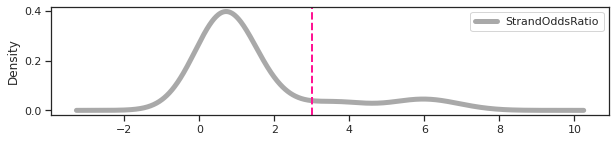

In [11]:
attr = 'SOR'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

#### Use recommended ReadPosRankSumTest (ReadPosRankSum) filter
This is the u-based z-approximation from the Rank Sum Test for site position within reads. It compares whether the positions of the reference and alternate alleles are different within the reads. Seeing an allele only near the ends of reads is indicative of error, because that is where sequencers tend to make the most errors. A negative value indicates that the alternate allele is found at the ends of reads more often than the reference allele; a positive value indicates that the reference allele is found at the ends of reads more often than the alternate allele. A value close to zero is best because it indicates there is little difference between the positions of the reference and alternate alleles in the reads.
  
The generic filtering recommendation for ReadPosRankSum is to filter out variants with ReadPosRankSum below -8. The distribution below supports the recommended cutoff: there is a single major peak around 0, indicating little difference between reference and alternate alleles of the reads.

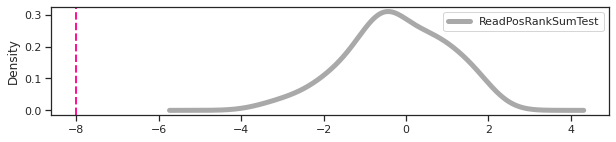

In [12]:
attr = 'ReadPosRankSum'
df = extract_attr(vcf_dict, vcf_info, attr, attrs[attr])
df.plot.kde(color='darkgray', linewidth=5, figsize=(10,2))
plt.axvline(x=cutoffs[attr], linewidth=2, color='DeepPink', ls='--')
plt.show()

## Validation of Variants

#### GATK4 method is more precise than the default method for target region

In [13]:
ref_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_REF), sep='\t')
target_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_TAR), sep='\t')
common_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_COMMON), sep='\t')

precision, sensitivity, f1 = accuracy_metrics("SG001_1_gatk.vcf", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
df_accuracy = pd.DataFrame({"SG001_1_gatk.vcf":[precision, sensitivity, f1]}, index = ['precision', 'sensitivity', 'f1'])
precision, sensitivity, f1 = accuracy_metrics("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
df_accuracy["SG001_1_GT.vcf.gz"] = [precision, sensitivity, f1]
df_accuracy

,SG001_1_gatk.vcf,SG001_1_GT.vcf.gz
precision,100.0,100.0
sensitivity,100.0,100.0
f1,100.0,100.0


#### GATK4 method has equivalent performance to baseline method in benchmarked target regions

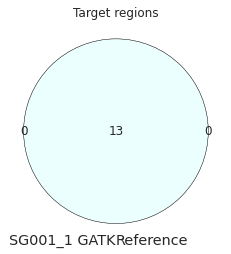

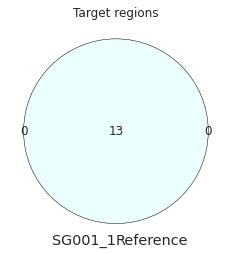

In [14]:
ref_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_REF), sep='\t')
target_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_TAR), sep='\t')
common_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_COMMON), sep='\t')
#display(common_vars.replace({'Files':{'3': 'SG001_1, SG001_2, reference'}}))

plot_var_venn("SG001_1_gatk.vcf", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')

#### GATK4 method outperforms baseline method if extended benchmarked regions are considered
Given that these are not target regions we do not look at False Negatives here, hence only Precision metric is valid.
* GATK4 approach has 100% precision
* GATK4 approach has better limit of detection

In [15]:
precision, sensitivity, f1 = accuracy_metrics("SG001_1_gatk.vcf", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
df_accuracy = pd.DataFrame({"SG001_1_gatk.vcf":[precision]}, index = ['precision'])
precision, sensitivity, f1 = accuracy_metrics("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
df_accuracy["SG001_1_GT.vcf.gz"] = [precision]
df_accuracy

,SG001_1_gatk.vcf,SG001_1_GT.vcf.gz
precision,100.0,97.22


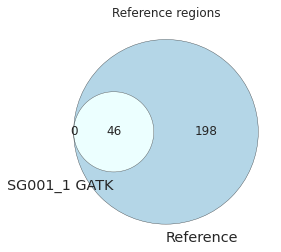

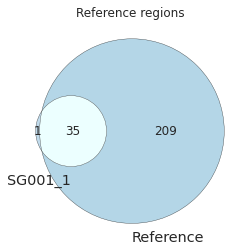

In [16]:
ref_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_REF), sep='\t')
target_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_TAR), sep='\t')
common_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_COMMON), sep='\t')
#display(common_vars.replace({'Files':{'3': 'SG001_1, SG001_2, reference'}}))

plot_var_venn("SG001_1_gatk.vcf", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')